# Assigning Sites to their Bioclimatic Groups

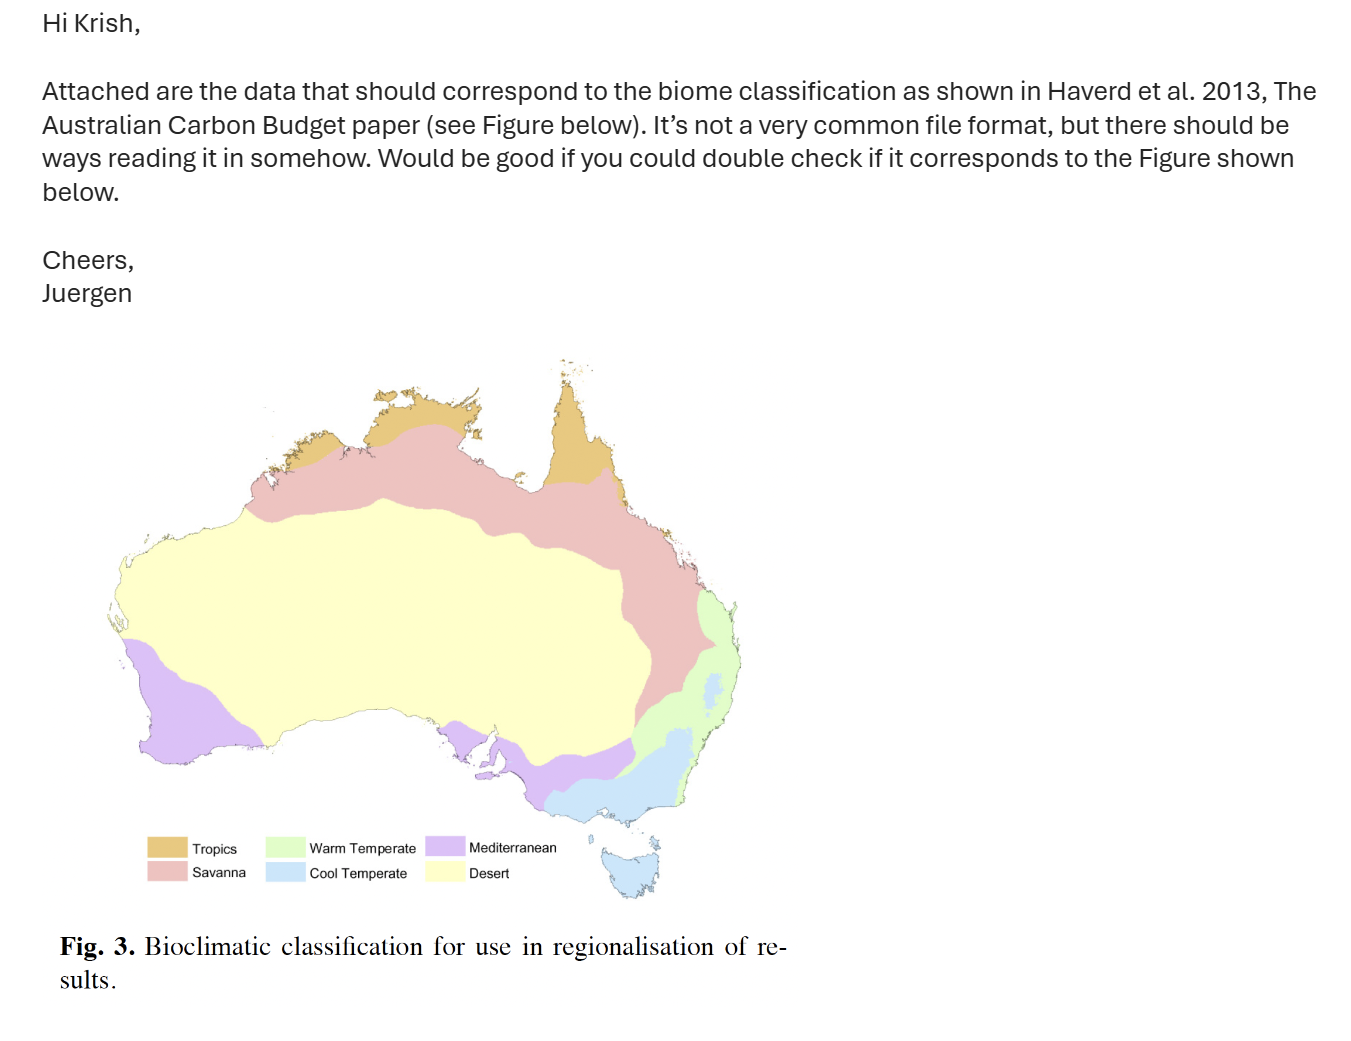

So the group codes are:

0 --> Unclassed

1 --> Tropical

2 --> Savanna

3 --> Warm temperate

4 --> Cool Temperate

5 --> Mediterranean

6 --> Desert

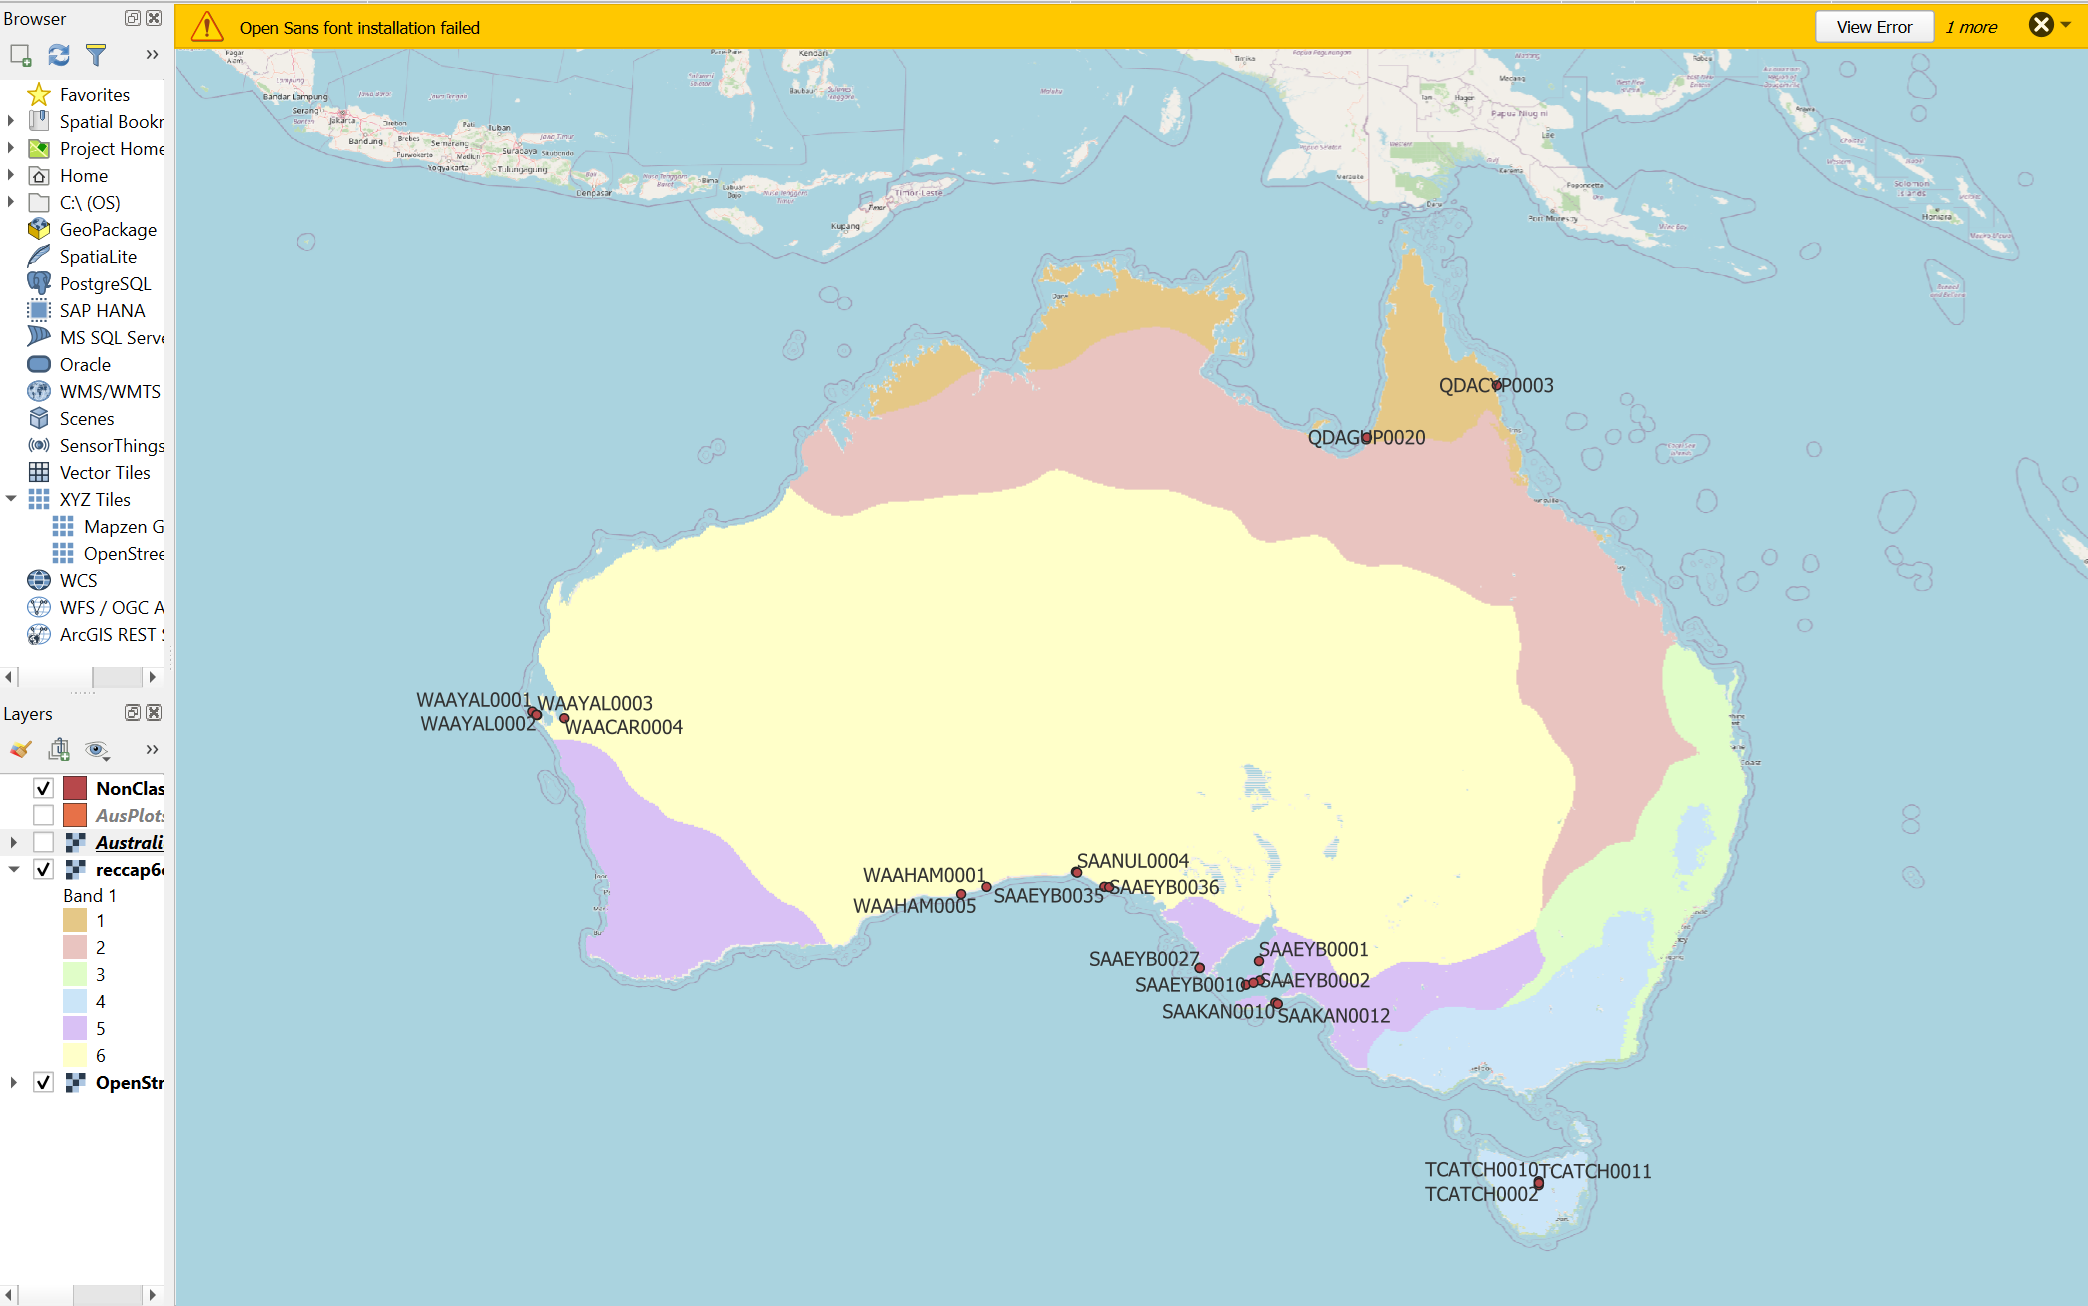

In [1]:
classifications = {0: 'Unclassed', 
                   1: 'Tropical',
                   2: 'Savanna',
                   3: 'Warm Temperate',
                   4: 'Cool Temperate',
                   5: 'Mediterranean',
                   6: 'Desert'}

In [2]:
import rasterio
import rasterio.mask
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import shape, mapping
import numpy as np
import os 
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, mapping
from shapely.geometry import Polygon

In [3]:
with fiona.open("../DATASETS/AusPlots_Location/AusPlots_Published_Corner_Points_20240701/Derived_Boundary_Polygons/AusPlots_Polygons_from_Published_Plots.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    shapes_name = [properties["properties"]['st_lct_'] for properties in shapefile]

In [4]:
column_names = ['Group_Code']
site_group_data = pd.DataFrame(columns = column_names, index = shapes_name)
site_group_data.head()

,Group_Code
NSABBS0001,NaN
NSABBS0002,NaN
NSABBS0003,NaN
NSABBS0004,NaN
NSABBS0005,NaN


In [5]:
file_path = '../DATASETS/Australian Bioclimatic Regions/Australian_Bioclimatic_Regions.tif'

with rasterio.open(file_path) as src:
    print(src)
    for i, s in enumerate(shapes):
        s = [s] # shape has to be in a list 
        shape_name = shapes_name[i] # reference the name of  the site 
        #print(shape_name)

        out_image, out_transform = rasterio.mask.mask(src, s, all_touched = True, crop=True, nodata = -999999) # perform masking
        out_image_filter = out_image[out_image != -999999]
        image_mean = np.nanmean(out_image_filter)
        site_group_data.loc[site_group_data.index == shape_name, 'Group_Code'] = image_mean

<open DatasetReader name='../DATASETS/Australian Bioclimatic Regions/Australian_Bioclimatic_Regions.tif' mode='r'>


C:\Users\krish\AppData\Local\Temp\ipykernel_43560\4268112276.py:12: RuntimeWarning: Mean of empty slice
  image_mean = np.nanmean(out_image_filter)
C:\Users\krish\AppData\Local\Temp\ipykernel_43560\4268112276.py:12: RuntimeWarning: Mean of empty slice
  image_mean = np.nanmean(out_image_filter)
C:\Users\krish\AppData\Local\Temp\ipykernel_43560\4268112276.py:12: RuntimeWarning: Mean of empty slice
  image_mean = np.nanmean(out_image_filter)
C:\Users\krish\AppData\Local\Temp\ipykernel_43560\4268112276.py:12: RuntimeWarning: Mean of empty slice
  image_mean = np.nanmean(out_image_filter)
C:\Users\krish\AppData\Local\Temp\ipykernel_43560\4268112276.py:12: RuntimeWarning: Mean of empty slice
  image_mean = np.nanmean(out_image_filter)
C:\Users\krish\AppData\Local\Temp\ipykernel_43560\4268112276.py:12: RuntimeWarning: Mean of empty slice
  image_mean = np.nanmean(out_image_filter)
C:\Users\krish\AppData\Local\Temp\ipykernel_43560\4268112276.py:12: RuntimeWarning: Mean of empty slice
  image_

In [6]:
site_group_data = site_group_data.fillna(0)
site_group_data = site_group_data.astype(int).astype(str)

C:\Users\krish\AppData\Local\Temp\ipykernel_43560\2305658339.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  site_group_data = site_group_data.fillna(0)


In [7]:
temp = dict()

for i in range(7):
    the_class = classifications[i]
    temp[the_class] = [len(site_group_data[site_group_data['Group_Code'] == str(i)])]

print(temp)

{'Unclassed': [17], 'Tropical': [60], 'Savanna': [124], 'Warm Temperate': [14], 'Cool Temperate': [42], 'Mediterranean': [85], 'Desert': [393]}


<Axes: >

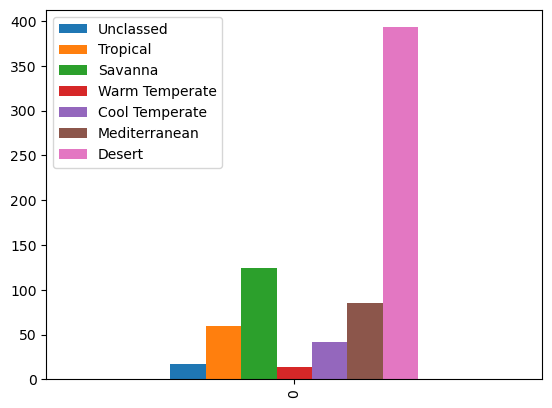

In [8]:
pd.DataFrame.from_dict(temp).plot.bar()

## Fixing the Non-classified Sites

In [9]:
non_classified = list(site_group_data[site_group_data['Group_Code'] == '0'].index)
print(non_classified)

['QDACYP0003', 'SAAEYB0002', 'SAAEYB0010', 'SAAEYB0027', 'SAAEYB0028', 'SAAKAN0010', 'SAAKAN0012', 'SAANUL0003', 'SAANUL0004', 'TCATCH0002', 'TCATCH0010', 'TCATCH0011', 'WAACAR0004', 'WAAHAM0001', 'WAAHAM0005', 'WAAYAL0002', 'WAAYAL0004']


In [10]:
# Create A shape file with the buffered 
with fiona.open('../DATASETS/AusPlots_Location/NonClassified_Buffered.shp', 'w', driver='ESRI Shapefile',
                crs= 'EPSG:4326', schema = {'geometry': 'Polygon',
                                           'properties': {'Name': 'str'}}) as shp:
    
    for n in non_classified:
        shape_name_indx = shapes_name.index(n)
        s = shapes[shape_name_indx]
        s_buffered = shape(s).buffer(0.15)
    
        shp.write({
            'geometry': mapping(s_buffered),
            'properties': {'Name': f'{n}'}
        })

In [11]:
with fiona.open("../DATASETS/AusPlots_Location/NonClassified_Buffered.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    shapes_name = [properties["properties"]['Name'] for properties in shapefile]

In [12]:
# Repeat Code But With the buffered sites 
file_path = '../DATASETS/Australian Bioclimatic Regions/Australian_Bioclimatic_Regions.tif'
with rasterio.open(file_path) as src:
    print(src)

    for i, s in enumerate(shapes):
        
        s = [s] # shape has to be in a list 
        shape_name = shapes_name[i] # reference the name of  the site
        print(shape_name)
        #print(shape_name)

        out_image, out_transform = rasterio.mask.mask(src, s, all_touched = True, crop=True, nodata = -999999) # perform masking
        out_image_filter = out_image[out_image != -999999]
        print(out_image_filter)
        
        image_mean = str(int(np.nanmean(out_image_filter)))       
        site_group_data.loc[site_group_data.index == shape_name, 'Group_Code'] = image_mean
        
        

<open DatasetReader name='../DATASETS/Australian Bioclimatic Regions/Australian_Bioclimatic_Regions.tif' mode='r'>
QDACYP0003
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
SAAEYB0002
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
SAAEYB0010
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
SAAEYB0027
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
SAAEYB0028
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
SAAKAN0010
[5. 5. 5. 5. 5. 5. 5. 5. 5.]
SAAKAN0012
[5. 5. 5. 5. 5. 5. 5. 5.]
SAANUL0003
[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
SAANUL0004
[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
TCATCH0002
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
TCATCH0010
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
TCATCH0011
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
WAACAR0004
[6. 6. 6. 6. 6. 

In [13]:
site_group_data.to_csv('../DATASETS/Australian Bioclimatic Regions/AusPlots_Bioregion_Classifications.csv')

## Now from the list we have

In [14]:
sites_list = pd.read_csv('../DATASETS/AusPlots_Extracted_Data/extracted_site_info_2-0-6.csv', index_col = 0)

In [15]:
sites_list = np.unique(sites_list['site.info.site_location_name'])

In [16]:
sites_list_current = set(sites_list).intersection(site_group_data.index)

In [17]:
site_group_data_current = site_group_data.iloc[site_group_data.index.isin(sites_list_current)]

{'Unclassed': [0], 'Tropical': [54], 'Savanna': [124], 'Warm Temperate': [14], 'Cool Temperate': [43], 'Mediterranean': [91], 'Desert': [374]}


<Axes: >

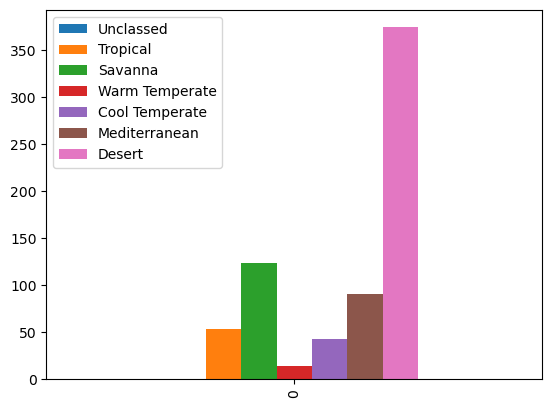

In [18]:
temp = dict()
for i in range(7):
    the_class = classifications[i]
    temp[the_class] = [len(site_group_data_current[site_group_data_current['Group_Code'] == str(i)])]
    
print(temp)
pd.DataFrame.from_dict(temp).plot.bar()

## Looking at all sufficiently complete sites

In [19]:
log = pd.read_csv('../DATASETS/DEA_FC_PROCESSED/MODELLED_PREPROCESSED/Log/Site_Preprocessing_Log_1.csv', index_col = 0)

In [20]:
log

,Error
NSABBS0001,NaN
NSABBS0002,NaN
NSABBS0003,NaN
NSABBS0004,1.0
NSABBS0005,1.0
...,...
WAAYAL0007,1.0
WAAYAL0008,1.0
WAGCOO0001,NaN
WAGCOO0002,NaN


In [21]:
log = log.fillna(0)
log = log.sort_values('Error')
log = log.astype(int).astype(str)

In [22]:
valid_site_list = list(log[(log['Error'] == '0')|(log['Error'] == '1')].index)

In [23]:
valid_site_list

['NSABBS0001',
 'SAAEYB0026',
 'SAAEYB0024',
 'SAAEYB0023',
 'SAAEYB0022',
 'SAAEYB0021',
 'SAAEYB0008',
 'QDASSD0015',
 'QDASSD0012',
 'WAGCOO0002',
 'QDASSD0009',
 'SAAEYB0027',
 'QDASSD0008',
 'QDASSD0006',
 'QDASSD0003',
 'QDASSD0002',
 'QDASSD0001',
 'QDASEQ0002',
 'QDAMUL0001',
 'QDAMII0002',
 'QDAMII0001',
 'QDAMGD0027',
 'QDAGUP0031',
 'QDASSD0007',
 'SAAEYB0029',
 'SAAEYB0032',
 'SAAFLB0005',
 'SATEYB0001',
 'SASMDD0018',
 'SASMDD0017',
 'SASMDD0016',
 'SASMDD0003',
 'SASMDD0002',
 'SASMDD0001',
 'SAASTP0008',
 'SAASTP0007',
 'SAARIV0006',
 'SAARIV0005',
 'SAARIV0004',
 'SAAKAN0010',
 'SAAKAN0009',
 'SAAKAN0008',
 'SAAKAN0007',
 'SAAKAN0006',
 'SAAKAN0005',
 'SAAKAN0004',
 'SAAKAN0003',
 'SAAKAN0002',
 'SAAGVD0003',
 'SAAFLB0006',
 'QDAGUP0030',
 'QDAGUP0029',
 'QDAGUP0027',
 'QDAGUP0024',
 'QDACYP0006',
 'QDACYP0005',
 'QDACYP0003',
 'QDACYP0002',
 'QDABBS0005',
 'QDABBS0004',
 'QDABBS0003',
 'QDABBS0002',
 'QDABBS0001',
 'NTTSTU0001',
 'NTTPCK0001',
 'NTTMGD0001',
 'NTTDMR00

In [24]:
sites_list_current_valid = set(site_group_data.index).intersection(valid_site_list)
print(len(sites_list_current_valid))
site_group_data_current_valid = site_group_data.iloc[site_group_data.index.isin(sites_list_current_valid)]

735


{'Unclassed': [0], 'Tropical': [61], 'Savanna': [124], 'Warm Temperate': [14], 'Cool Temperate': [45], 'Mediterranean': [91], 'Desert': [400]}


<Axes: >

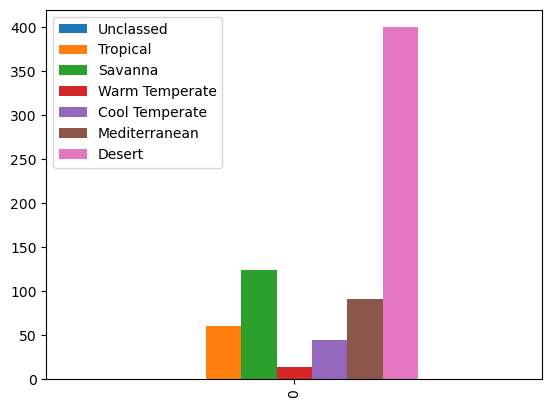

In [25]:
temp = dict()
for i in range(7):
    the_class = classifications[i]
    temp[the_class] = [len(site_group_data_current_valid[site_group_data_current_valid['Group_Code'] == str(i)])]
    
print(temp)
pd.DataFrame.from_dict(temp).plot.bar()

In [26]:
site_group_data_current_valid.value_counts()

Group_Code
6             400
2             124
5              91
1              61
4              45
3              14
Name: count, dtype: int64

In [27]:
site_group_data_current_valid

,Group_Code
NSABBS0001,3
NSABBS0002,3
NSABBS0003,2
NSABBS0004,2
NSABBS0005,2
...,...
WAGCOO0001,6
WAGCOO0002,6
WAGCOO0004,6
QDASEQ0001,3


In [28]:
site_group_data_current_valid.to_csv('../DATASETS/Australian Bioclimatic Regions/AusPlots_BioclimaticRegion_Classified.csv')

In [29]:
classifications = pd.DataFrame.from_dict({0: ['Unclassed'], 
                   1: ['Tropical'],
                   2: ['Savanna'],
                   3: ['Warm Temperate'],
                   4: ['Cool Temperate'],
                   5: ['Mediterranean'],
                   6: ['Desert']})

In [30]:
classifications = classifications.T

In [31]:
classifications['Code'] = classifications.index

In [32]:
classifications = classifications.rename(columns = {0: 'Classification'})

In [33]:
classifications.to_csv('../DATASETS/Australian Bioclimatic Regions/Classifications_Reference.csv')